In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import CubicSpline
import flygym.mujoco
import flygym.mujoco.preprogrammed
from tqdm import trange
from pathlib import Path

output_path = Path("./outputs")
output_path.mkdir(exist_ok=True)

In [2]:
def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_frequencies : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amplitudes : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators."""
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = (
                self.random_state.random(self.num_cpgs) * self.intrinsic_amps
            )
        else:
            self.curr_magnitudes = init_magnitudes

In [17]:
# Loading the data
single_step_directory = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets")
single_steps_path = single_step_directory/"RF_0stance_RM_0stance_RH_0stance.pkl"
single_steps_path
print(f"Loading {single_steps_path}...")

with open(single_steps_path, "rb") as f:
    single_steps_data = pickle.load(f)
preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]
print(
    f"Preprogrammed steps have a length of {preprogrammed_steps_length} steps "
    f"at dt={preprogrammed_steps_timestep}s."
)

Loading /Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets/RF_0stance_RM_0stance_RH_0stance.pkl...
Preprogrammed steps have a length of 45 steps at dt=0.001s.


In [18]:
use_file = True

In [19]:

from flygym.common import get_data_path
if not use_file:
    path = get_data_path("flygym", "data") / "behavior/single_steps_new.pkl"
    with open(path, "rb") as f:
        single_steps_data = pickle.load(f)
    preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
    preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]
    print(
        f"Preprogrammed steps have a length of {preprogrammed_steps_length} steps "
        f"at dt={preprogrammed_steps_timestep}s."
    )

In [20]:
#Check that the data is consistent
for k, v in single_steps_data.items():
    if k.startswith("joint_"):
        assert len(v) == preprogrammed_steps_length
        #assert v[0] == v[-1]

    legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
    "Coxa",
    "Coxa_roll",
    "Coxa_yaw",
    "Femur",
    "Femur_roll",
    "Tibia",
    "Tarsus1",
]

# Interpolate the data
phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
psi_funcs = {}
for leg in legs:
    joint_angles = np.array(
        [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
    )
    
    psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")

    theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    joint_angles_by_leg[leg] = psi_func(theta_ts)

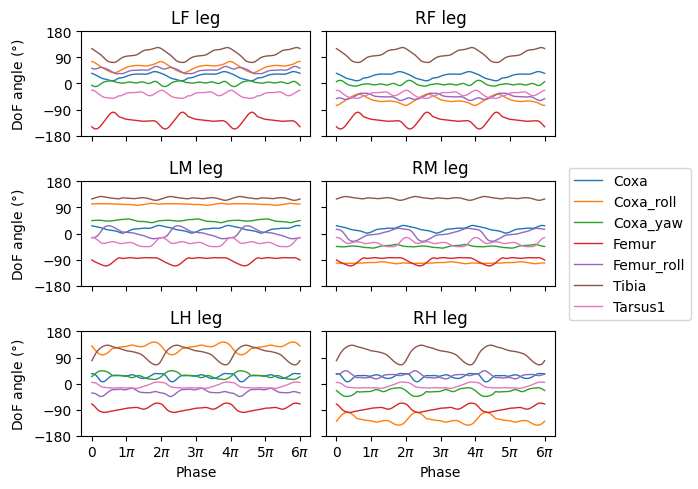

In [21]:
# Plot the joint angles
fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else f"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig("./outputs/three_steps.png")


In [22]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 100

tmstp = 1e-4

cpg_network = CPGNetwork(
    timestep=tmstp,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

In [23]:
swing_start = np.empty(6)
swing_end = np.empty(6)
start_type = [[] for _ in range(6)]
for i, leg in enumerate(legs):
    swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
    swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_start *= 2 * np.pi
swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_end *= 2 * np.pi

# have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
psi_rest_phases = np.ones_like(swing_start)
for i, leg in enumerate(legs):
    psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    

# Add adhesion

In [24]:
def get_adhesion_onoff(theta):
    theta = theta % (2 * np.pi)
    return ~((theta > swing_start) & (theta < swing_end)).squeeze()

# Run one normal

100%|██████████| 50000/50000 [01:26<00:00, 580.65it/s]


66.44854736328125 -25.769800186157227


Text(0, 0.5, 'y [mm]')

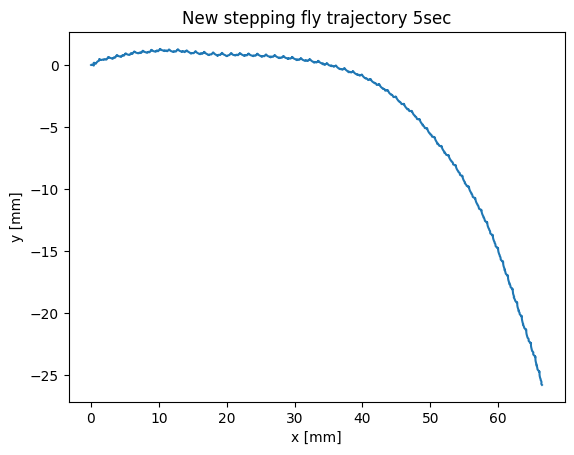

In [25]:
run_time = 5
cam_name = "Animat/camera_left"
#kp = 50.0
#stifness = 10.0
#damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    )

#np.random.seed(0)
fly_traj = []

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.1,
    enable_adhesion=True,  # THIS HAS CHANGED
    draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
    render_camera=cam_name,
    actuator_gain=50.0
)
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
    control="position",
    xml="mjcf_ikpy_model",
)

obs, info = nmf.reset()

for i in trange(int(run_time / sim_params.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):

        psi = psi_funcs[leg]( cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    adhesion_onoff = get_adhesion_onoff(cpg_network.curr_phases)
    
    action = {
        "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
        ##### THIS LINE IS NEW #####
        "adhesion": adhesion_onoff.astype(int),
        ############################
    }
    try:
        obs, reward, terminated, truncated, info = nmf.step(action)
    except Exception as e:
        print(e)
        break
    nmf.render()

    fly_traj.append(obs["fly"][0][:2])

cam_loc = cam_name.split("_")[-1]
nmf.save_video(f"./videos/cpg_controller_with_adhesion_cam{cam_loc}_tmstp{tmstp}_base_step.mp4", stabilization_time=0)

print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])

plt.plot(np.array(fly_traj)[:, 0], np.array(fly_traj)[:, 1])
plt.title("New stepping fly trajectory 5sec")
plt.xlabel("x [mm]")
plt.ylabel("y [mm]")


# Silence some dofs

In [12]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=42)

for mirrored in [True, False]:
    for dof_to_cancel in ["None"] + dofs_per_leg:
        np.random.seed(42)
        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=True,  # THIS HAS CHANGED
            draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose="stretch",
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        joints_to_keep = np.ones(len(dofs_per_leg), dtype=int)
        if dof_to_cancel != "None":
            dof_to_cancel_index = dofs_per_leg.index(dof_to_cancel)
            joints_to_keep[dof_to_cancel_index] = 0

        cpg_network.random_state = np.random.RandomState(42)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1] #np.concatenate([cpg_network.curr_phases[3:], cpg_network.curr_phases[:3]])
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]*joints_to_keep
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            adhesion_onoff = get_adhesion_onoff(cpg_phases)
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                ##### THIS LINE IS NEW #####
                "adhesion": adhesion_onoff.astype(int),
                ############################
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()

            fly_traj.append(obs["fly"][0][:2])

        #cam_loc = cam_name.split("_")[-1]
        #nmf.save_video(f"./videos/cpg_controller_with_adhesion_cam{cam_loc}_kp{kp}_tmstp{tmstp}_mirrored{mirrored}.mp4", stabilization_time=0)
        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"{dof_to_cancel}_mirrored{mirrored}")

100%|██████████| 50000/50000 [01:03<00:00, 781.88it/s]


75.48029327392578 21.580692291259766


100%|██████████| 50000/50000 [01:10<00:00, 708.00it/s]


73.00702667236328 -10.843960762023926


100%|██████████| 50000/50000 [01:22<00:00, 609.70it/s]


70.17935180664062 -4.990274429321289


100%|██████████| 50000/50000 [01:07<00:00, 745.62it/s]


50.153995513916016 -48.93840026855469


100%|██████████| 50000/50000 [00:49<00:00, 1019.24it/s]


-24.897369384765625 26.156885147094727


100%|██████████| 50000/50000 [01:34<00:00, 528.78it/s]


50.582481384277344 -0.7612385153770447


100%|██████████| 50000/50000 [01:06<00:00, 751.03it/s]


4.560360908508301 17.404510498046875


100%|██████████| 50000/50000 [00:59<00:00, 844.11it/s]


80.84723663330078 -15.260979652404785


100%|██████████| 50000/50000 [01:05<00:00, 765.92it/s]


71.68785858154297 31.549570083618164


100%|██████████| 50000/50000 [01:10<00:00, 711.70it/s]


72.1638412475586 -12.489377975463867


100%|██████████| 50000/50000 [01:27<00:00, 569.86it/s]


59.36779022216797 26.74851417541504


100%|██████████| 50000/50000 [01:07<00:00, 738.03it/s]


31.225112915039062 -51.33143997192383


100%|██████████| 50000/50000 [00:40<00:00, 1229.36it/s]


10.329608917236328 3.9772493839263916


100%|██████████| 50000/50000 [01:38<00:00, 508.03it/s]


49.72758865356445 -0.0663842037320137


100%|██████████| 50000/50000 [01:02<00:00, 793.79it/s]


-1.3331983089447021 11.671889305114746


100%|██████████| 50000/50000 [01:00<00:00, 825.11it/s]

59.6256103515625 51.71901321411133


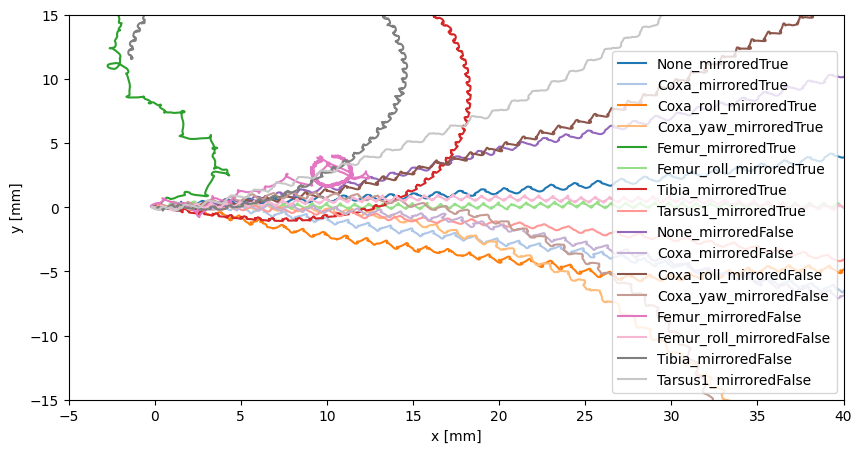

In [13]:
plt.figure(figsize=(10, 5))
colors = plt.cm.tab20.colors

for i, (traj, en) in enumerate(zip(fly_trajs, exp_names)):
    traj = np.array(traj)
    if len(traj) > 0:
        plt.plot(traj[:, 0], traj[:, 1], label=en, color=colors[i])
    else:
        plt.plot(np.nan, np.nan, label=en, color = colors[i])

plt.xlabel("x [mm]")
plt.ylabel("y [mm]")
plt.xlim(-5, 40)
plt.ylim(-15, 15)
plt.legend()
plt.show()

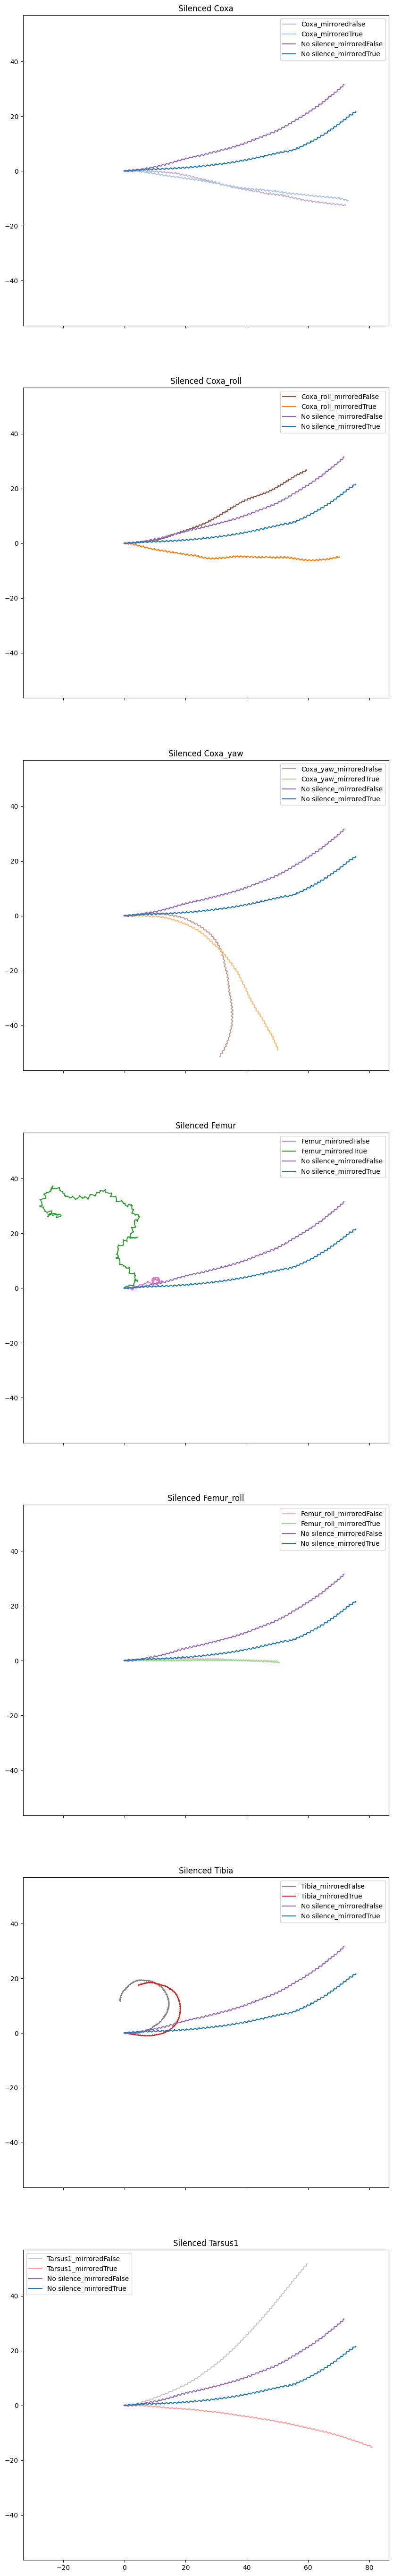

In [14]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(len(dofs_per_leg), 1, figsize=(10, 70), sharex=True, sharey=True)
axs = axs.flatten()
colors = plt.cm.tab20.colors

reference_traces = exp_names.index("None_mirroredFalse"), exp_names.index("None_mirroredTrue")

for i, dof in enumerate(dofs_per_leg):
    plot_traces = exp_names.index(f"{dof}_mirroredFalse"), exp_names.index(f"{dof}_mirroredTrue")
    for index in plot_traces:
        traj = np.array(fly_trajs[index])
        if len(traj) > 0:
            axs[i].plot(traj[:, 0], traj[:, 1], label=exp_names[index], color=colors[index])
        else:
            axs[i].plot(np.nan, np.nan, label=exp_names[index], color=colors[index])
    for index in reference_traces:
        traj = np.array(fly_trajs[index])
        if len(traj) > 0:
            axs[i].plot(traj[:, 0], traj[:, 1], label=exp_names[index].replace("None", "No silence"), color=colors[index])
        else:
            axs[i].plot(np.nan, np.nan, label=exp_names[index], color=colors[index])
    axs[i].set_title(f"Silenced {dof}")
    axs[i].legend()

# Lower the timestep

100%|██████████| 499999/499999 [07:55<00:00, 1052.31it/s]


Text(0, 0.5, 'y [mm]')

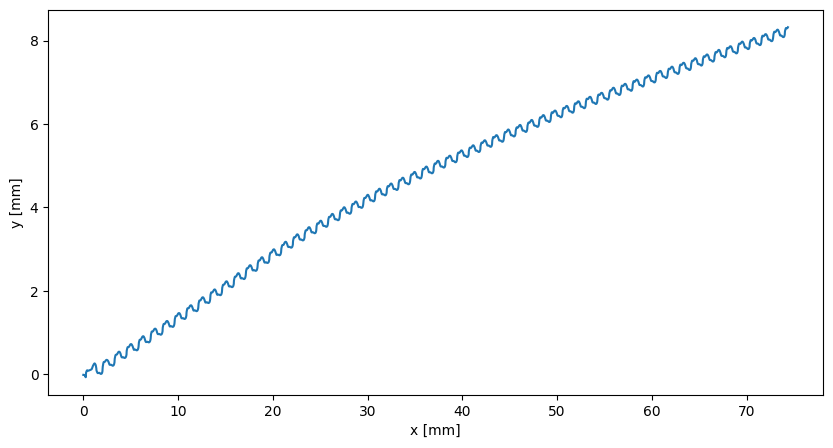

In [26]:
tmstp = 1e-5

cpg_network = CPGNetwork(
    timestep=tmstp,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=0
)

run_time = 5.0
fly_traj = []
sim_params = flygym.mujoco.Parameters(
    timestep=tmstp,
    render_mode="saved",
    render_playspeed=0.05,
    enable_adhesion=False,  # THIS HAS CHANGED
    draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
    render_camera=cam_name,
    tarsus_damping=damping,
    tarsus_stiffness=stifness
)
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
    control="position",
    xml="mjcf_ikpy_model"
)

obs, info = nmf.reset()
fly_traj.append(obs["fly"][0][:2])

for i in trange(int(run_time / sim_params.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    adhesion_onoff = get_adhesion_onoff(cpg_network.curr_phases)
    
    action = {
        "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
        ##### THIS LINE IS NEW #####
        "adhesion": adhesion_onoff.astype(int),
        ############################
    }
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    fly_traj.append(obs["fly"][0][:2])

nmf.save_video(f"./videos/cpg_controller_with_adhesion_cam{cam_name.split('_')[-1]}_kp{kp}_tmstp{tmstp}_adhesion_{nmf.sim_params.enable_adhesion}.mp4", stabilization_time=0)

plt.figure(figsize=(10, 5))
fly_traj = np.array(fly_traj)
plt.plot(fly_traj[:, 0], fly_traj[:, 1])
plt.xlabel("x [mm]")
plt.ylabel("y [mm]") 


# Influence of random seed

In [27]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=42)

for mirrored in [True, False]:
    for seed in np.arange(2):
        np.random.seed(seed)

        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=True,  # THIS HAS CHANGED
            draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose="stretch",
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        cpg_network.random_state = np.random.RandomState(seed)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1] #np.concatenate([cpg_network.curr_phases[3:], cpg_network.curr_phases[:3]])
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            adhesion_onoff = get_adhesion_onoff(cpg_phases)
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                ##### THIS LINE IS NEW #####
                "adhesion": adhesion_onoff.astype(int),
                ############################
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()

            fly_traj.append(obs["fly"][0][:2])

       
        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"seed{seed}_mirrored{mirrored}")

100%|██████████| 50000/50000 [00:50<00:00, 985.07it/s] 


63.27757263183594 -31.769166946411133


100%|██████████| 50000/50000 [00:50<00:00, 980.41it/s] 


63.644142150878906 -30.11991310119629


100%|██████████| 50000/50000 [00:49<00:00, 1004.13it/s]


66.44854736328125 -25.769800186157227


100%|██████████| 50000/50000 [00:50<00:00, 997.26it/s] 

64.87419128417969 -27.914302825927734


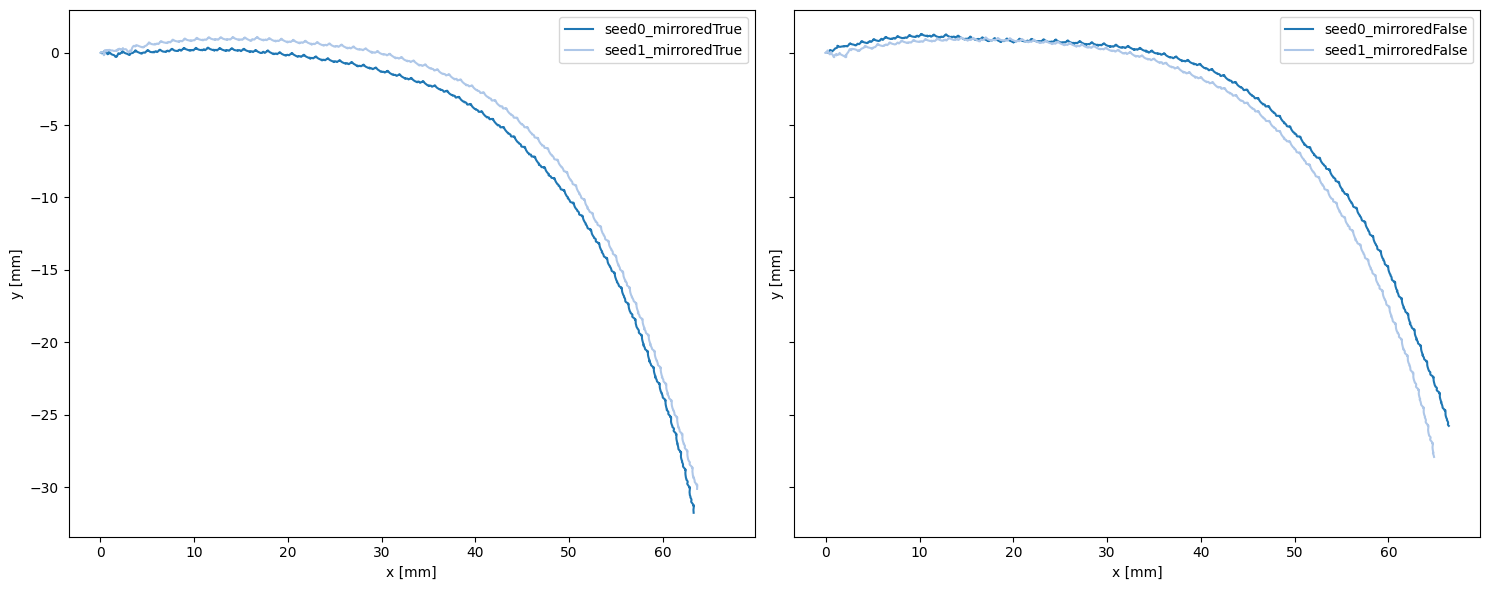

: 

In [28]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
colors = plt.cm.tab20.colors

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    color_id = int(exp_names[i].split("_")[0][4:])
    plot_ax = 0 if "True" in exp_names[i] else 1
    if len(traj) > 0:
        axs[plot_ax].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_ax].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])
for ax in axs:
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")

plt.tight_layout()
plt.show()


# Imapact of R

In [ ]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []



for mirrored in [True, False]:
    for conv_coeff in np.arange(0, 100, 10):
        np.random.seed(seed)

        cpg_network = CPGNetwork(
            timestep=1e-4,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=np.ones(6) * conv_coeff,
            seed=42)

        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=True,  # THIS HAS CHANGED
            draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose="stretch",
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        cpg_network.random_state = np.random.RandomState(seed)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1] #np.concatenate([cpg_network.curr_phases[3:], cpg_network.curr_phases[:3]])
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            adhesion_onoff = get_adhesion_onoff(cpg_phases)
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                ##### THIS LINE IS NEW #####
                "adhesion": adhesion_onoff.astype(int),
                ############################
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()

            fly_traj.append(obs["fly"][0][:2])

       
        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"cc{conv_coeff}_mirrored{mirrored}")

100%|██████████| 50000/50000 [01:16<00:00, 654.87it/s]


4.58449649810791 16.8538818359375


100%|██████████| 50000/50000 [01:02<00:00, 796.00it/s]


63.41853332519531 45.506324768066406


100%|██████████| 50000/50000 [01:04<00:00, 780.53it/s]


63.690879821777344 44.75796890258789


100%|██████████| 50000/50000 [01:02<00:00, 801.42it/s]


66.27114868164062 41.44627380371094


100%|██████████| 50000/50000 [01:02<00:00, 796.32it/s]


67.1239242553711 40.5628776550293


100%|██████████| 50000/50000 [00:59<00:00, 838.23it/s]


72.53338623046875 -27.2232608795166


100%|██████████| 50000/50000 [00:59<00:00, 836.48it/s]


69.613037109375 -34.753456115722656


100%|██████████| 50000/50000 [00:59<00:00, 839.31it/s]


71.82246398925781 -31.00740623474121


100%|██████████| 50000/50000 [01:04<00:00, 776.67it/s]


71.29411315917969 35.36188507080078


100%|██████████| 50000/50000 [01:01<00:00, 808.88it/s]


62.76997756958008 48.7233772277832


100%|██████████| 50000/50000 [01:17<00:00, 647.37it/s]


6.4451212882995605 15.715581893920898


100%|██████████| 50000/50000 [01:02<00:00, 801.66it/s]


79.85923767089844 -2.7882819175720215


100%|██████████| 50000/50000 [01:01<00:00, 807.51it/s]


71.41180419921875 -29.779294967651367


100%|██████████| 50000/50000 [01:01<00:00, 807.80it/s]


68.91023254394531 -36.541542053222656


100%|██████████| 50000/50000 [01:04<00:00, 772.87it/s]


67.99853515625 39.02485656738281


100%|██████████| 50000/50000 [01:02<00:00, 803.90it/s]


74.13972473144531 -25.497098922729492


100%|██████████| 50000/50000 [01:02<00:00, 803.12it/s]


71.73585510253906 -32.32783889770508


100%|██████████| 50000/50000 [01:02<00:00, 803.66it/s]


71.8255844116211 -28.78949546813965


100%|██████████| 50000/50000 [01:02<00:00, 800.70it/s]


70.95299530029297 -33.44182586669922


100%|██████████| 50000/50000 [01:02<00:00, 803.17it/s]

72.98558807373047 -28.809415817260742


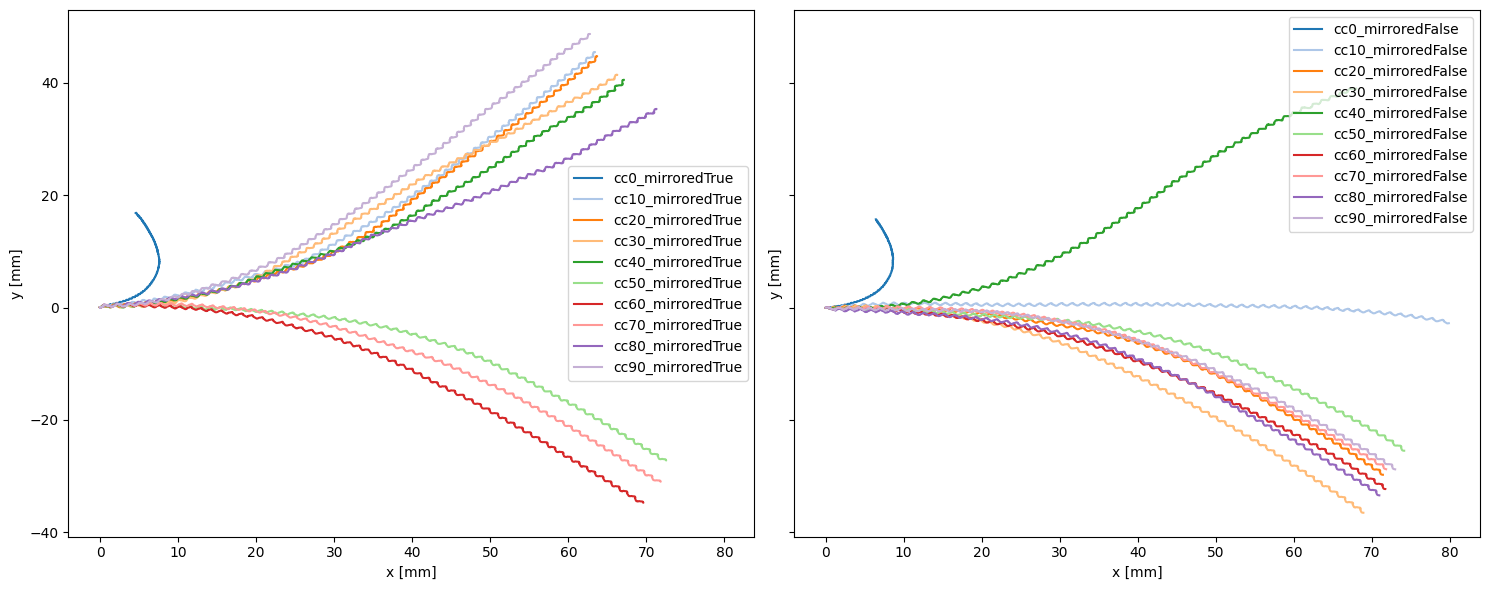

In [ ]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
colors = plt.cm.tab20.colors

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    color_id = int(exp_names[i].split("_")[0][2:])//10
    plot_ax = 0 if "True" in exp_names[i] else 1
    if len(traj) > 0:
        axs[plot_ax].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_ax].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])
for ax in axs:
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")

plt.tight_layout()
plt.show()

# Impact of Kp

In [ ]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []



for mirrored in [True, False]:
    for kp in np.arange(20.0, 50.0, 5.0):
        np.random.seed(seed)

        cpg_network = CPGNetwork(
            timestep=1e-4,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=np.ones(6) * conv_coeff,
            seed=42)

        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=True,  # THIS HAS CHANGED
            draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness,
            actuator_gain=kp
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose="stretch",
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        cpg_network.random_state = np.random.RandomState(seed)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1] #np.concatenate([cpg_network.curr_phases[3:], cpg_network.curr_phases[:3]])
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            adhesion_onoff = get_adhesion_onoff(cpg_phases)
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                ##### THIS LINE IS NEW #####
                "adhesion": adhesion_onoff.astype(int),
                ############################
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()

            fly_traj.append(obs["fly"][0][:2])

       
        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"kp{kp}_mirrored{mirrored}")

100%|██████████| 50000/50000 [00:45<00:00, 1101.44it/s]


48.54472732543945 -6.297170162200928


100%|██████████| 50000/50000 [00:43<00:00, 1155.19it/s]


52.29142761230469 -8.25052547454834


100%|██████████| 50000/50000 [00:43<00:00, 1155.78it/s]


61.46152114868164 -7.379332542419434


100%|██████████| 50000/50000 [00:43<00:00, 1140.13it/s]


68.25086975097656 -0.09462875872850418


100%|██████████| 50000/50000 [00:43<00:00, 1150.62it/s]


61.40176010131836 24.74139976501465


100%|██████████| 50000/50000 [00:42<00:00, 1178.33it/s]


13.545331954956055 46.92743682861328


100%|██████████| 50000/50000 [00:45<00:00, 1104.17it/s]


49.18601989746094 -6.488550186157227


100%|██████████| 50000/50000 [00:43<00:00, 1152.60it/s]


51.653770446777344 -9.062472343444824


100%|██████████| 50000/50000 [00:43<00:00, 1150.17it/s]


59.6725959777832 -9.126239776611328


100%|██████████| 50000/50000 [00:43<00:00, 1140.08it/s]


66.22834777832031 2.9749412536621094


100%|██████████| 50000/50000 [00:43<00:00, 1143.44it/s]


46.37126159667969 41.158050537109375


100%|██████████| 50000/50000 [00:42<00:00, 1184.62it/s]

29.560550689697266 40.63825607299805


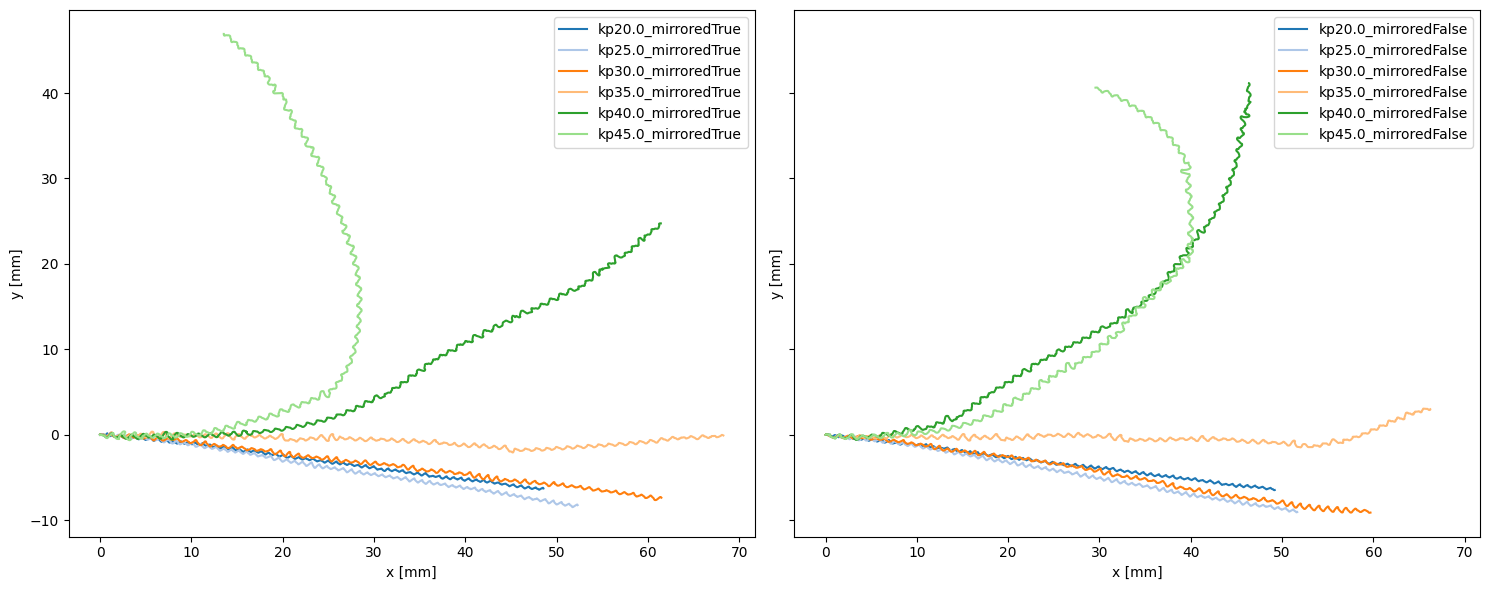

In [ ]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
colors = plt.cm.tab20.colors

color_map = {}
color_counter = [0, 0]

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0][2:]
    plot_ax = 0 if "True" in exp_names[i] else 1
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_ax]
        color_counter[plot_ax] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_ax].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_ax].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])
for ax in axs:
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")

plt.tight_layout()
plt.show()

# Effect of start pose

In [ ]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []



for mirrored in [True, False]:
    for pose in ["stretch", "tripod"]:
        np.random.seed(seed)

        cpg_network = CPGNetwork(
            timestep=1e-4,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=42)

        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=True,  # THIS HAS CHANGED
            draw_adhesion=True,  # THIS HAS CHANGED (tarsus color indicates adhesion on/off)
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness,
            actuator_gain=kp
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose=pose,
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        cpg_network.random_state = np.random.RandomState(seed)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1] 
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            adhesion_onoff = get_adhesion_onoff(cpg_phases)
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                ##### THIS LINE IS NEW #####
                "adhesion": adhesion_onoff.astype(int),
                ############################
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()
            fly_traj.append(obs["fly"][0][:2])

        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"pose{pose}_mirrored{mirrored}")

100%|██████████| 50000/50000 [01:03<00:00, 793.50it/s]


61.036067962646484 49.887664794921875


100%|██████████| 50000/50000 [01:05<00:00, 766.09it/s]


71.68112182617188 33.55401611328125


100%|██████████| 50000/50000 [01:03<00:00, 783.13it/s]


68.00126647949219 -38.87944793701172


100%|██████████| 50000/50000 [01:00<00:00, 832.73it/s]

64.55888366699219 -48.421653747558594


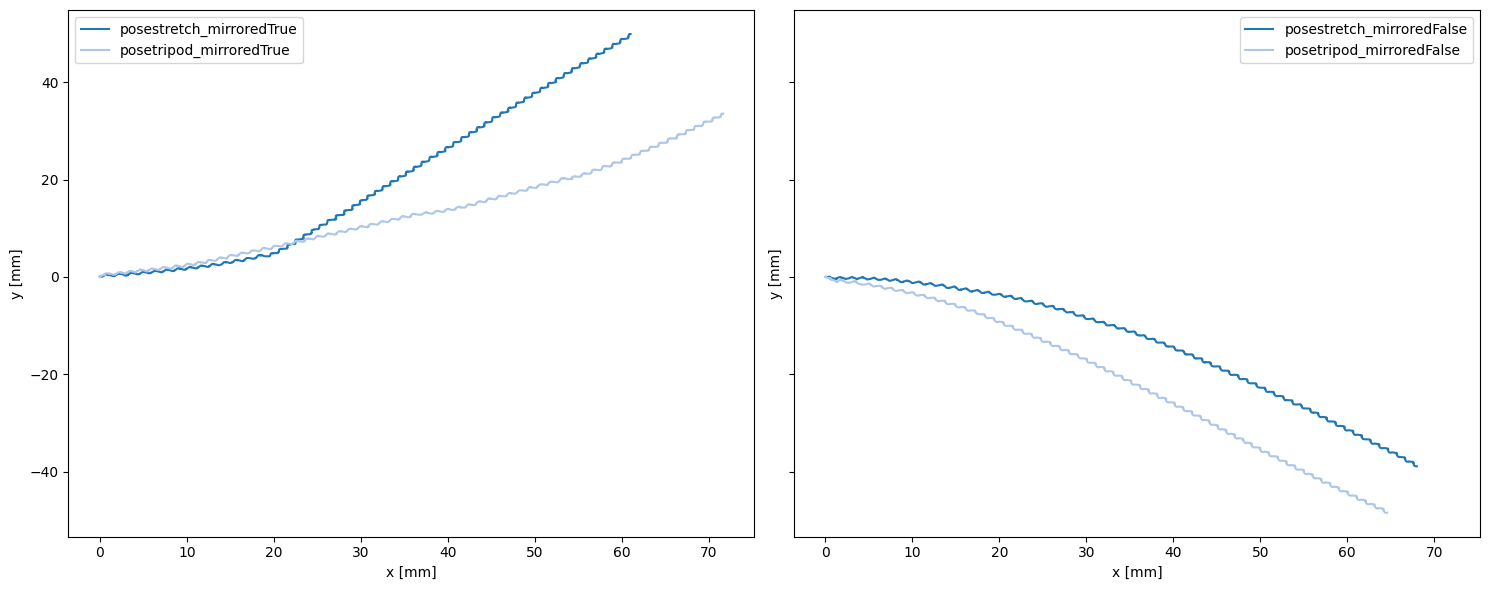

In [ ]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
axs = axs.flatten()
colors = plt.cm.tab20.colors

color_map = {}
color_counter = [0, 0]

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0][2:]
    plot_ax = 0 if "True" in exp_names[i] else 1
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_ax]
        color_counter[plot_ax] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_ax].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_ax].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])
for ax in axs:
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    #ax.set_ylim(-0.1, 0.25)
    #ax.set_xlim(-0.25, 0.25)

plt.tight_layout()
plt.show()

# Try release tether